# Introduction
Source: https://www.kaggle.com/competitions/elo-merchant-category-recommendation/data

### Table of Contents
- [Libraries](#libraries)
- [Utils](#utils)
- [Datasets](#datasets)
- [EDA](#eda)
- [Imputation](#imputation)
- [Feature Engineering](#feature-engineering)
- [Feature Selection](#feature-selection)
- [Machine Learning](#machine-learning)

### Libraries <a id="libraries"></a>

In [56]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Tools
import math
import datetime
from typing import List, Union

# ML Tools
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# CONSTANTS
SEED = 123
TEST_PERC = 0.05

import warnings
warnings.filterwarnings("ignore")

import unittest
import threading

### Utilts <a id="utils"></a>

In [57]:
def summarizeDF(df:DataFrame)->DataFrame:
    """This function shows a basic summary of the given dataframe.
    
    Parameters
    ----------
    df: pandas DataFrame
    This specifies the dataframe to be summarized.
    
    Returns
    -------
    pandas DataFrame: This is a table of summary of the given dataset.
    """    
    variables, dtypes, count, unique, missing, pc_missing = [], [], [], [], [], []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'column_name': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'percentage_missing_data': pc_missing
    })    
        
    return output

def preprocess_data(df:DataFrame=None)->DataFrame:
    """This function preprocess the data into a specific form for the computation.
    Given a DataFrame (df), impute with mode.
    
    Parameters
    ----------
    df: pandas DataFrame
    This specifies the data to be preprocessed.
    
    Returns
    -------
    DataFrame: This specifies the preprocessed DataFrame.
    """
    if df is None:
        raise Exception("Expected a DataFrame, no DataFrame supplied.")
    
    df_copy = df.copy()
    for col in df.columns[df.isnull().any()]:
        df_copy[col].fillna(df_copy['card_id'].map(df_copy.groupby('card_id')[col].apply(lambda x: x.mode().iloc[0] if not x.isnull().all() else np.nan)).fillna(df_copy[col].mode().iloc[0]), inplace=True)

    return df_copy

def feature_engineering(df:DataFrame=None)->DataFrame:
    """This function perform feature engineering on the input Data"""
    
    def get_new_columns(name:str, aggs:list)->list: # Nested function for feature engineering
        """This function creates new column names for the aggregation of the features."""
        return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    
    # Make copy of df
    df_historical_transactions_copy = df.copy()
 
    # Convert DT columns to Pandas DT
    df_historical_transactions_copy['purchase_date'] = pd.to_datetime(df_historical_transactions_copy['purchase_date'])
 
    # Feature Engineer columns from purchase_date
    df_historical_transactions_copy['year'] = df_historical_transactions_copy['purchase_date'].dt.year
    df_historical_transactions_copy['weekofyear'] = df_historical_transactions_copy['purchase_date'].dt.isocalendar().week
    df_historical_transactions_copy['month'] = df_historical_transactions_copy['purchase_date'].dt.month
    df_historical_transactions_copy['dayofweek'] = df_historical_transactions_copy['purchase_date'].dt.dayofweek
    df_historical_transactions_copy['weekend'] = (df_historical_transactions_copy.purchase_date.dt.weekday >=5).astype(int)
    df_historical_transactions_copy['hour'] = df_historical_transactions_copy['purchase_date'].dt.hour
 
    # Encode Binary Features
    df_historical_transactions_copy['authorized_flag'] = df_historical_transactions_copy['authorized_flag'].map({"Y":1, 'N':0})
    df_historical_transactions_copy['category_1'] = df_historical_transactions_copy['category_1'].map({'Y':1, 'N':0})
 
    # Feature Engineer Month Diff/Lag
    df_historical_transactions_copy['month_diff'] = ((datetime.datetime.today() - df_historical_transactions_copy['purchase_date']).dt.days)//30
    df_historical_transactions_copy['month_diff'] += df_historical_transactions_copy['month_lag']
    
    # Getting Centrality of the Data
    aggs = {}
    for col in ['month','hour','weekofyear','dayofweek','year', 'state_id','subsector_id']:
        aggs[col] = ['nunique']
 
    # Feature Engineering using Univariate Analysis
    aggs['authorized_flag'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    aggs['category_1'] = ['sum', 'mean']
    aggs['installments'] = ['sum','max','min','mean','var']
    aggs['month_lag'] = ['max','min','mean','var']
    aggs['purchase_amount'] = ['sum','max','min','mean','var']
    aggs['purchase_date'] = ['max','min']
    aggs['month_diff'] = ['mean']
    aggs['weekend'] = ['sum', 'mean']
 
    for col in ['category_2','category_3']:
        df_historical_transactions_copy[col+'_mean'] = df_historical_transactions_copy.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']    
 
    new_columns = get_new_columns('hist',aggs)
    
    # Group Aggregations by card_id
    df_historical_transactions_copy_group = df_historical_transactions_copy.groupby('card_id').agg(aggs)
 
    # Remove Multilevel Indexing with New Column Names
    df_historical_transactions_copy_group.columns = new_columns
    
    # Reset Index
    df_historical_transactions_copy_group.reset_index(drop=False,inplace=True)
    
    # Cast variable to pandas Datetime
    df_historical_transactions_copy_group['hist_purchase_date_max'] = pd.to_datetime(df_historical_transactions_copy_group['hist_purchase_date_max'])
    df_historical_transactions_copy_group['hist_purchase_date_min'] = pd.to_datetime(df_historical_transactions_copy_group['hist_purchase_date_min'])

    return df_historical_transactions_copy_group

def merge_data(key:str=None, dfs:List[DataFrame]=None)->DataFrame:
    """This function takes in multiple dataframes and performs a left outer join on a key.
    
    Parameters
    ----------
    key: str
    This species the joining key.
    
    dfs: list of pandas DataFrame
    This specifies the list of DataFrames to perform left outer join based on a key.
    
    Returns
    -------
    pandas DataFrame: This specifies the resultant DataFrame from the merging operation.
    """
    
    # Sanity Check
    if key is None:
        raise Exception("Expected a key, no key supplied.")
        
    if not isinstance(key, str):
        raise Exception(f"Expected type str for key, {type(key)} was supplied.")
    
    if dfs is None or not len(dfs) == 2:
        raise Exception("Expected at least two DataFrame.")
        
    if any(type(x) != DataFrame for x in dfs):
        raise Exception("At least one DataFrame is not the correct DataType.")
        
    # Iterate through DataFrames to perform merge operation
    df_res = dfs[0]
    
    for df in dfs[1:]:
        df_res = pd.merge(left=df_res, right=df, how='left', left_on=key, right_on=key)
    
    return df_res

def zhenjie_miracle(df:DataFrame)->DataFrame:
    """This function perform feature engineering on purchase_max and purchase_min and one-hot encoding on the 
    input Data which must be a merged dataframe of train dataset and trans (hist and new) dataset after running 
    feature_engineering function"""
    
    # Make copy of df
    df_historical_transactions_copy_group = df.copy()

    brazil_holiday_list=[ 
            '01-01-17', '14-02-17', '28-08-17', '14-04-17', '16-04-17', '21-04-17',
            '01-05-17', '15-06-17', '07-09-17', '12-10-17', '02-11-17', '15-11-17', 
            '24-12-17', '25-12-17', '31-12-17',
            '01-01-18', '14-02-18', '28-08-18', '14-04-18', '16-04-18', '21-04-18',
            '01-05-18', '15-06-18', '07-09-18', '12-10-18', '02-11-18', '15-11-18', 
            '24-12-18', '25-12-18', '31-12-18'
      ]
    df_historical_transactions_copy_group['purchase_max_is_holiday'] = df_historical_transactions_copy_group['hist_purchase_date_max'].isin(brazil_holiday_list).astype(int)
    df_historical_transactions_copy_group['purchase_min_is_holiday'] = df_historical_transactions_copy_group['hist_purchase_date_min'].isin(brazil_holiday_list).astype(int)
    
    df_historical_transactions_copy_group_dummies = pd.get_dummies(df_historical_transactions_copy_group['feature_1'], prefix='feature_1', drop_first=True)
    df_historical_transactions_copy_group = pd.concat([df_historical_transactions_copy_group, df_historical_transactions_copy_group_dummies], axis=1)
    df_historical_transactions_copy_group_dummies = pd.get_dummies(df_historical_transactions_copy_group['feature_2'], prefix='feature_2', drop_first=True)
    df_historical_transactions_copy_group = pd.concat([df_historical_transactions_copy_group, df_historical_transactions_copy_group_dummies], axis=1)

    return df_historical_transactions_copy_group


def pengaik_miracle(df:DataFrame=None)->DataFrame:
    
    """This function perform feature engineering on average monthly purchase amount raw of positive month lags 
    over that of negative. It also performs feature engineering on the ratio of purchase amount raw of 
    month_lag=i/month_lag=i-1 for each card_id and returns the average ratio as a column
    input Data which must be a concat dataframe of trans (hist and new) dataset """
    
    transactions_copy = df.copy()
    
    # Reverse purchase_amount
    transactions_copy['purchase_amount_raw'] = np.round(transactions_copy['purchase_amount'] / 0.00150265118 + 497.06, 2)

    # Group transactions_copy by card_id and month_lag
    grouped_transactions_copy = transactions_copy.groupby(['card_id', 'month_lag']).agg({'purchase_amount_raw': 'mean'}).reset_index()

    # Separate transactions_copy into two groups based on month_lag
    lag_le_0 = grouped_transactions_copy[grouped_transactions_copy['month_lag'] <= 0]
    lag_gt_0 = grouped_transactions_copy[grouped_transactions_copy['month_lag'] > 0]

    # Calculate the monthly average purchase amount for each group
    lag_le_0_monthly_average_raw = lag_le_0.groupby('card_id')['purchase_amount_raw'].mean().reset_index().rename(columns={'purchase_amount_raw': 'monthly_average_purchase_amount_raw_for_month_lag_le_0'})
    lag_gt_0_monthly_average_raw = lag_gt_0.groupby('card_id')['purchase_amount_raw'].mean().reset_index().rename(columns={'purchase_amount_raw': 'monthly_average_purchase_amount_raw_for_month_lag_gt_0'})

    # Merge the new columns with the original transactions_copy dataframe
    transactions_copy = transactions_copy.merge(lag_le_0_monthly_average_raw, on='card_id', how='left')
    transactions_copy = transactions_copy.merge(lag_gt_0_monthly_average_raw, on='card_id', how='left')

    transactions_copy['ratio_between_ave_monthly_purchase_raw_for_positive_and_negative'] = transactions_copy['monthly_average_purchase_amount_raw_for_month_lag_gt_0'] / transactions_copy['monthly_average_purchase_amount_raw_for_month_lag_le_0']

    # Find the minimum month_lag for each card_id and set the index to 'card_id'
    min_month_lag_per_card = transactions_copy.groupby('card_id', as_index=False)['month_lag'].min().set_index('card_id')

    # Fill in missing month_lag values for each card_id
    unique_card_ids = transactions_copy['card_id'].unique()
    min_month_lag = transactions_copy['month_lag'].min()
    max_month_lag = transactions_copy['month_lag'].max()

    complete_data = []

    for card_id in unique_card_ids:
        # Use .loc[] accessor to look up the minimum month_lag for each card_id
        card_min_month_lag = min_month_lag_per_card.loc[card_id]['month_lag']
        for month_lag in range(card_min_month_lag, max_month_lag + 1):
            complete_data.append([card_id, month_lag, 0])

    complete_transactions_copy = pd.DataFrame(complete_data, columns=['card_id', 'month_lag', 'purchase_amount_raw'])

    # Compute the purchase_amount_raw sum for each card_id and month_lag combination
    grouped_transactions_copy = transactions_copy.groupby(['card_id', 'month_lag'], as_index=False)['purchase_amount_raw'].sum()

    # Merge the complete_transactions_copy dataframe with the grouped_transactions_copy dataframe
    merged_transactions_copy = pd.merge(complete_transactions_copy, grouped_transactions_copy, on=['card_id', 'month_lag'], how='left', suffixes=('', '_y'))
    merged_transactions_copy['purchase_amount_raw'] = merged_transactions_copy['purchase_amount_raw_y'].fillna(merged_transactions_copy['purchase_amount_raw'])

    # Calculate the ratio of purchase_amount_raw for each month_lag=i/month_lag=i-1
    merged_transactions_copy['prev_month_purchase_amount'] = merged_transactions_copy.groupby('card_id')['purchase_amount_raw'].shift(1)
    merged_transactions_copy['ratio'] = np.where(merged_transactions_copy['prev_month_purchase_amount'] != 0, merged_transactions_copy['purchase_amount_raw'] / merged_transactions_copy['prev_month_purchase_amount'], np.nan)

    # Compute the average of these ratios for each card_id
    average_ratios = merged_transactions_copy.groupby('card_id', as_index=False)['ratio'].mean()

    # Handling division by zero cases by replacing np.inf with np.nan and then replacing np.nan with a suitable value (e.g., 1)
    average_ratios['ratio'] = average_ratios['ratio'].replace([np.inf, -np.inf], np.nan).fillna(1)

    # Merge average_ratios with transactions_copy DataFrame
    feature_engineered_transactions_copy = transactions_copy.merge(average_ratios, on='card_id', how='left')

    return feature_engineered_transactions_copy



ModelRegressor = Union[LinearRegression, DecisionTreeRegressor, RandomForestRegressor]
def feature_selection(approach:str="RFE", 
                      k:int=10, 
                      train:DataFrame=None, 
                      test:DataFrame=None,
                      model:ModelRegressor=None)->List[str]:
    """This function performs feature selection based on the user's choice of approach.
    
    Usage
    -----
    >> features = feature_selection(approach="LGBM", train=X_train, test=y_train)
    """
    # TODO: Sanity check for input
    # TODO: Documentation for inputs
    if approach == 'LGBM':
        # LGTM Regressor to pick out important features
        gbm = lgb.LGBMRegressor()
        gbm.fit(train, test)

        # Feature Important Viz
        fea_imp_ = pd.DataFrame({'variable':train.columns, 'feature_importance':gbm.feature_importances_})
        return list(fea_imp_[:k]['variable'])
    if approach == 'RFE':
        rfe = RFE(estimator=model, n_features_to_select=k)
        rfe = rfe.fit(train, test)

        # summarize the ranking of the attributes
        fea_rank_ = pd.DataFrame({'variable': train.columns, 'feature_importance':rfe.ranking_})
        return list(fea_rank_[:k]['variable'])

    
def build_train_test_sets(df:DataFrame=None, 
                          features:List[str]=None, 
                          target:str=None, 
                          verbose:int=0, 
                          **kwargs:dict)->List[DataFrame]:
    """This function splits the given dataframe into train and test data.
    
    Parameters
    ----------
    Args:
        df: DataFrame
        This specifies the source DataFrame.

        features: list of str
        This list containing a str-type elements specifies the name of the features.

        target: str
        This specifies the target variable.
        
        verbose: int-type
            This species the verbosity of the function.
    
    Kwargs
        A dict mapping the corresponding parameters for scikit learn model selection. 
        
        {"test_size": 0.05, "seed": None}
    
        If a key from the keys argument is missing from the settings, the default will be used.
        
    Returns
    -------
    list: This species the list containing X_train, X_test, y_test and y_train DataFrame.
    """
    # Default 
    model_params = {
        'test_size': 0.05,
        "seed": None
    }
    
    # Sanity Check
    if df is None:
        raise ValueError("Expected a DataFrame, no DataFrame supplied.")
        
    if features is None:
        raise Exception("Expected a features list, no features list supplied.")
    
    if not isinstance(features, list):
        raise Exception(f"Expected list datatype for features, {type(features)} was supplied.")
        
    if not isinstance(target, str):
        raise Exception(f"Expected str datatype for target, {type(target)} was supplied.")
        
    # Check for Kwargs
    if "test_size" in kwargs:
        model_params['test_size'] = kwargs["test_size"]
    if "seed" in kwargs:
        model_params['seed'] = kwargs["seed"]
        
    seed = "No Seed" if model_params["seed"] is None else model_params['seed']
    if verbose != 0:
        print(f"***Parameters for Model Selection***\ntest_size {model_params['test_size']}\nseed: {seed}\n")
    
    if seed != "No Seed":
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[[target]], test_size=model_params['test_size'])
        return X_train, X_test, y_train, y_test
    else:
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[[target]], test_size=model_params['test_size'], random_state=model_params['seed'])
        return X_train, X_test, y_train, y_test
    
def train_eval_model(model:ModelRegressor,  X_train, X_test, y_train, y_test, name)->DataFrame:
    """This function trains and evaluates the model.
    By default, the score used it RMSE.

    Parameters
    ----------

    Args:
        model: model
        This species the model to use for training and evaluation.
       
    Kwargs
        A dict mapping the corresponding parameters for training and test data. 
        
        {"X_train": ..., "X_test": ..., "y_train": ..., "y_test": ...}
    
    Return 
    ------
    dataframe: This specifies resets from testing the model.
    """
    # Train
    model.fit(X_train, y_train)

    # Pred
    y_pred = model.predict(X_test)

    # Eval
    print(f"{name} Score:", math.sqrt(mean_squared_error(y_test, y_pred)))
    
    return y_pred


def Bayesian_Optimization(objective_function, parameters_dict, n_init_random_explorations=10, n_iter = 50):
    """Find the hyperparameters that maximizes a given objective (e.g test result)
    Parameters
    ----------
    Args:
        objective_function: function
        function that outputs a value, which BO will try to maximize. 

        parameters_dict: Dictionary
        Contain hyperparameters that you want to optimize. Key is hyperparameter name, value is (min, max) value of that hyperparameters
        
        n_init_random_explorations: int
        Number of random sets of hyperparameters to try. <n_init_random_explorations> random hp sets are explored before <n_iter> systematic explorations are run
        
        n_iter: int
        Number of iterations to run
        
    Returns
    -------
    Dict: Best set of hyperparameters


    Usage
    -------
    The key in pbounds must match the parameters in objective_function!!!

    def objective_function(n, beta, gamma) -> float:
      n = int(n)
      model = BetaVae(
          n_latent=n,
          beta=beta,
          n_chan=N_CHAN,
          input_d=INPUT_DIM,
          batch=BATCH,
          gamma = gamma,
          )
      model.train_self(
          data_path=TRAIN_PATH,
          epochs=1,
          weights_file=f'bvae_n{n}_b{beta}_{"bw" if N_CHAN == 1 else ""}_'
                      f'{INPUT_DIM[0]}x{INPUT_DIM[1]}.pt')
      return model.test(TEST_PATH, iters=1)

    parameters_dict = {'n': (5, 200), 'beta': (0.1,30), 'gamma': (0.001, 30)}

    def Bayesian_Optimization(objective_function, parameters_dict, n_iter = 50):
      optimizer = BayesianOptimization(
          f=objective_function,
          pbounds= parameters_dict,
          verbose=2,
          random_state=1)
    
    best_hypers = Bayesian_Optimization(objective_function, parameters_dict, n_iter = 50)
    """
    optimizer = BayesianOptimization(
        f=objective_function, #define before this function
        pbounds=parameters_dict, 
        random_state=1)
    optimizer.maximize(init_points=n_init_random_explorations, n_iter=n_iter)
    print('#################################################################')
    print(f'Found Network with Optimal target result of {optimizer.max["target"]}')
    print(f'Parameters: {optimizer.max["params"]}')
    print('#################################################################')
    return optimizer.max["params"]


def createData(df_left:DataFrame, df_right:DataFrame, output_path:str=None) -> DataFrame:
    """This function creates the testing dataset."""
    # Execute Peng Aik's Miracle
    df_left = pengaik_miracle(df_left)
 
    # Feature Engineering
    df_left = feature_engineering(df_left)
 
    # Merge Transactions and Train
    df_right_merge = merge_data('card_id', [df_right, df_left])
 
    # Execute Zhen Jie's Miracle
    df_right_merge = zhenjie_miracle(df_right_merge)
 
    # Remove Missing Data Cause of Test Data
    df_right_merge.dropna(inplace=True) # JX COMMENT OUT BECAUSE THIS FUNCTION IS USED TO GENERATE TEST DATASET WITH EXACTLY 123623 ROWS
 
    # Engineered by Zhen Jie so Remove
    df_right_merge.drop(columns=['first_active_month'], inplace=True)
    df_right_merge.drop(columns=['hist_purchase_date_max', 'hist_purchase_date_min'], inplace=True)
 
    # Output CSV
    if output_path:
        df_right_merge.to_csv(output_path)
 
    return df_right_merge

### Datasets <a id="datasets"></a>

1. Customer has a ```card_id``` as uuid.
2. Each customer can make at least one transaction to merchants.
3. Merchant has ```merchant_id``` as uuid.

In [58]:
# Historical Transactions
tp = pd.read_csv('/kaggle/input/elo-merchant-category-recommendation/historical_transactions.csv', iterator=True, chunksize=2_000_000)  # gives TextFileReader, which is iterable with chunks of 1000 rows.
df_historical_transactions = pd.concat(tp, ignore_index=True) 

# New Historical Transactions
tp = pd.read_csv('/kaggle/input/elo-merchant-category-recommendation/new_merchant_transactions.csv', iterator=True, chunksize=2_000_000)  # gives TextFileReader, which is iterable with chunks of 1000 rows.
df_new_historical_transactions = pd.concat(tp, ignore_index=True) 

# Train Data
df_train = pd.read_csv('/kaggle/input/elo-merchant-category-recommendation/train.csv')

# Engineered Train Data 
tp = pd.read_csv('/kaggle/input/cz4041-preprocessed/output.csv',index_col=0, iterator=True, chunksize=5_000_000)  # gives TextFileReader, which is iterable with chunks of 1000 rows.
df_train_merge = pd.concat(tp, ignore_index=True)

In [59]:
df_train_merge.drop(columns=['hist_state_id_nunique', 'hist_subsector_id_nunique', 'hist_authorized_flag_mean', 'hist_authorized_flag_sum', 'hist_category_1_mean', 'hist_category_1_sum', 'hist_category_2_mean_mean', 'hist_category_3_mean_mean'], inplace=True)

In [60]:
df_train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   card_id                    201917 non-null  object 
 1   feature_1                  201917 non-null  float64
 2   feature_2                  201917 non-null  float64
 3   feature_3                  201917 non-null  float64
 4   target                     201917 non-null  float64
 5   hist_month_nunique         201917 non-null  int64  
 6   hist_hour_nunique          201917 non-null  int64  
 7   hist_weekofyear_nunique    201917 non-null  int64  
 8   hist_dayofweek_nunique     201917 non-null  int64  
 9   hist_year_nunique          201917 non-null  int64  
 10  hist_card_id_size          201917 non-null  int64  
 11  hist_installments_sum      201917 non-null  int64  
 12  hist_installments_max      201917 non-null  int64  
 13  hist_installments_min      20

### Machine Learning <a id='machine-learning'></a>

In [84]:
# Split Dataset
features = list(df_train_merge.drop(columns=['target', 'card_id']).columns)
target = 'target'
X_train, X_test, y_train, y_test = build_train_test_sets(df_train_merge, 
                                                        features=features,
                                                        target='target')

print("X_train:", X_train.shape)
print("y_train:", y_train.shape, end='\n\n')

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Feature Selection
train = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
test = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Use LGBM for Selection
features = feature_selection(approach="LGBM", train=train, test=test)

X_train: (191821, 34)
y_train: (191821, 1)

X_test: (10096, 34)
y_test: (10096, 1)


In [85]:
# Initialize Model
gbm = lgb.LGBMRegressor()
lr = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=5)
gbm = lgb.LGBMRegressor()

# Use Features from Feature Selection
X_train, X_test = X_train[features], X_test[features]

# Threading to Speed Up Comparison
t1 = threading.Thread(target=train_eval_model, args=(gbm, X_train, X_test, y_train, y_test, 'GBM'))
t2 = threading.Thread(target=train_eval_model, args=(lr, X_train, X_test, y_train, y_test, 'LR'))
t3 = threading.Thread(target=train_eval_model, args=(dtr, X_train, X_test, y_train, y_test, 'DTR'))
t4 = threading.Thread(target=train_eval_model, args=(gbm, X_train, X_test, y_train, y_test, 'LGBM'))

t1.start()
t2.start()
t3.start()
t4.start()

Output seems be very dependent on the spliting, perform KFold CV.

Let's take LGBM and perform KFoldCV.

In [86]:
# Perform KFold CV for LGBM
gbm = lgb.LGBMRegressor()

kf_cv = KFold(n_splits=100, shuffle=True)
scores = cross_val_score(gbm, 
                         train[features], 
                         test, 
                         scoring='neg_root_mean_squared_error', 
                         cv=kf_cv, 
                         n_jobs=-1, # Concurrency
                         verbose=1
                        )

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


LR Score: 3.78998580825794
DTR Score: 3.7620527212180117
LGBM Score: 3.7629021521544246
GBM Score: 3.7629021521544246


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


In [87]:
scores = [-score for score in scores]

In [88]:
print("Min Score:", min(scores))
print("Max Score:", max(scores))

Min Score: 3.0963477512291635
Max Score: 4.636094010771839


<AxesSubplot:>

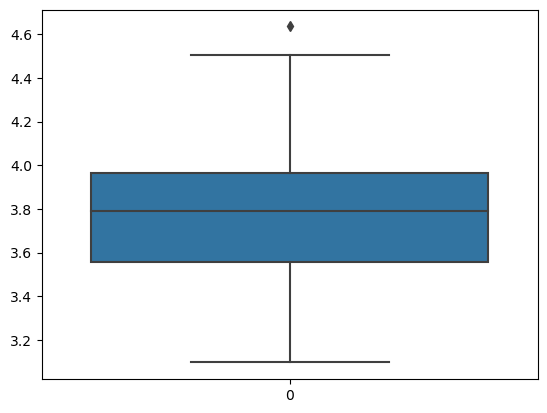

In [89]:
# Hmmm... How does the spread look?
sns.boxplot(scores)

### Hyperparameter Tuning

From the docs...

```
For Better Accuracy:
- Use large max_bin (may be slower)
- Use small learning_rate with large num_iterations
- Use large num_leaves (may cause over-fitting)
- Use bigger training data
- Try dart

Deal with Over-fitting
- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction
- Use bigger training data
- Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
- Try max_depth to avoid growing deep tree
- Try extra_trees
- Try increasing path_smooth
```

#### RandomForest Hyperparameter tuning

use randomizedCV to narrow down the params then use gridCV based on this narrowed range

## Grid and random search

In [95]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   3.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   3.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   3.5s
[CV] END bootstrap=True, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5; total time=   2.2s
[CV] END bootstrap=True, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5; total time=   2.1s
[CV] END bootstrap=True, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5; total time=   2.1s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=32, min_samples_split=16, n_estimators=5; total time

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 32,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}

In [97]:
best_random = rf_random.best_estimator_
y_predict = best_random.predict(X_test)
print("Score:", math.sqrt(mean_squared_error(y_test, y_predict))) 

Score: 3.7600674016636337


In [106]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [9, 10, 11, 12, 13],
    'max_features': ['sqrt'],
    'min_samples_leaf': [i for i in range (30, 35)],
    'min_samples_split': [2, 3, 4, 5, 8],
    'n_estimators': [i for i in range (98, 103)]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 625 candidates, totalling 1875 fits
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=98; total time=   7.7s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=98; total time=   7.9s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=98; total time=   7.6s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=99; total time=   7.7s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=99; total time=   7.8s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=99; total time=   8.0s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=30, min_samples_split=2, n_estimators=100; total tim

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 34,
 'min_samples_split': 2,
 'n_estimators': 102}

In [107]:
best_random = grid_search.best_estimator_
y_predict = best_random.predict(X_test)
print("Score:", math.sqrt(mean_squared_error(y_test, y_predict))) 

Score: 3.760687723789041


In [108]:
# Prepare Test Dataset
df_test = pd.read_csv('/kaggle/input/compiled-test/test.csv')

In [109]:
card_id = df_test.card_id.unique()
df_test.drop(columns=['first_active_month', 'card_id'], inplace=True)
df_Test_trial = df_test[features]

In [110]:
# Predict
y_test_predict = best_random.predict(df_Test_trial)
df_test_predict = pd.DataFrame({'card_id': card_id, 'target': y_test_predict})

# Save to csv
df_test_predict.to_csv('d4.csv', index=False)